# PWC Optimization

In [1]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import qctrlvisualizer as qv
import qutip as qt
from scipy.optimize import minimize, OptimizeResult


@dataclass
class OptimizationResult:
    result: OptimizeResult
    times: npt.NDArray[np.float64]
    params: npt.NDArray[np.float64]
    pulse: npt.NDArray[np.complex128]

    def plot(self):
        pulse = np.append(self.pulse, self.pulse[-1])
        plt.step(self.times, np.real(pulse), where="post", label="I")
        plt.step(self.times, np.imag(pulse), where="post", label="Q")
        plt.grid(color="gray", linestyle="--", alpha=0.2)
        plt.legend()
        plt.show()


@dataclass
class SimulationResult:
    times: npt.NDArray[np.float64]
    unitaries: list[qt.Qobj]
    states: list[qt.Qobj]
    infidelities: list[float]

    @property
    def dimension(self) -> int:
        return self.states[0].shape[0]

    @property
    def populations(self) -> npt.NDArray:
        return np.abs(np.array(self.states).squeeze()) ** 2

    def display_bloch_sphere(self):
        states = np.array(self.states).squeeze()
        qv.display_bloch_sphere(states[:, :2])

    def plot_populations(self):
        qv.plot_population_dynamics(
            sample_times=self.times,
            populations={
                rf"$|{k}\rangle$": self.populations[:, k] for k in range(self.dimension)
            },
        )

    def print_final_populations(self):
        population = self.populations[-1]
        for k in range(self.dimension):
            print(f"|{k}> : {population[k]:>6.2%}")

    def plot_unitary_infidelities(self):
        plt.plot(
            self.times,
            self.infidelities,
            "x",
            color="black",
            label="Infidelity",
        )
        plt.plot(
            self.times,
            self.infidelities,
            "--",
            color="black",
            alpha=0.5,
            linewidth=1,
        )
        plt.grid(color="gray", linestyle="--", alpha=0.2)
        plt.ylim(0, 1)


class PulseOptimizer:
    def __init__(
        self,
        dimension: int,
        detuning: float,
        anharmonicity: float,
        segment_count: int,
        segment_width: float,
    ):
        self.dimension = dimension
        self.detuning = detuning
        self.anharmonicity = anharmonicity
        self.segment_count = segment_count
        self.segment_width = segment_width
        self.duration = segment_count * segment_width
        self.times = np.linspace(0, self.duration, segment_count + 1)
        self.a = qt.destroy(self.dimension)
        self.ad = self.a.dag()
        self.H_sys = self.system_hamiltonian()

    def system_hamiltonian(self) -> qt.Qobj:
        omega = 2 * np.pi * self.detuning
        alpha = 2 * np.pi * self.anharmonicity
        a = self.a
        ad = self.ad
        H_sys = omega * ad * a + 0.5 * alpha * ad * ad * a * a
        return H_sys

    def pwc_unitary(self, value: complex) -> qt.Qobj:
        H_ctrl = 0.5 * (self.ad * value + self.a * np.conj(value))
        H = self.H_sys + H_ctrl
        U = (-1j * H * self.segment_width).expm()
        return U

    def objective_function(self, params: npt.NDArray[np.float64]) -> float:
        pulse = self.params_to_pulse(params)
        U = qt.qeye(self.dimension)
        for value in pulse:
            U = self.pwc_unitary(value) * U
        return self.unitary_infidelity(U, self.target_unitary)

    def unitary_infidelity(self, U1: qt.Qobj, U2: qt.Qobj) -> float:
        return 1 - np.abs((U1.dag() * U2).tr() / self.dimension) ** 2

    def random_params(self) -> npt.NDArray[np.float64]:
        return np.random.uniform(-1, 1, 2 * self.segment_count)

    def params_to_pulse(
        self,
        params: npt.NDArray[np.float64],
    ) -> npt.NDArray[np.complex128]:
        params = params.reshape((self.segment_count, 2))
        return params[:, 0] + 1j * params[:, 1]

    def optimize(
        self,
        initial_params: npt.NDArray[np.float64],
        target_unitary: qt.Qobj,
    ) -> npt.NDArray[np.float64]:
        self.target_unitary = target_unitary
        result = minimize(
            self.objective_function,
            initial_params,
            method="BFGS",
        )
        params = result.x
        pulse = self.params_to_pulse(params)
        return OptimizationResult(
            result=result,
            times=self.times,
            params=params,
            pulse=pulse,
        )

    def simulate(self, pulse: npt.NDArray[np.complex128]) -> dict:
        unitaries = [qt.qeye(self.dimension)]
        states = [qt.basis(self.dimension, 0)]
        infidelities = [0.0]
        for value in pulse:
            U = self.pwc_unitary(value) * unitaries[-1]
            unitaries.append(U)
            state = U * states[0]
            states.append(state)
            infidelity = self.unitary_infidelity(U, self.target_unitary)
            infidelities.append(infidelity)
        return SimulationResult(
            times=self.times,
            unitaries=unitaries,
            states=states,
            infidelities=infidelities,
        )

In [2]:
optimizer = PulseOptimizer(
    dimension=3,
    detuning=0.0,
    anharmonicity=-0.3,
    segment_count=10,
    segment_width=2.0,
)

In [3]:
initial_params = optimizer.random_params()
initial_params

array([-0.82414908, -0.37687342,  0.24816085,  0.99671206,  0.57228851,
       -0.28420531,  0.75084175, -0.38867849, -0.43271174,  0.97936696,
       -0.29775188, -0.24959638, -0.82049664, -0.80412377,  0.95559595,
        0.07995583,  0.6823612 , -0.09191751,  0.63423973, -0.71571425])

In [4]:
target_unitary = qt.qeye(3)
target_unitary

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

In [5]:
opt_result = optimizer.optimize(
    initial_params=initial_params,
    target_unitary=target_unitary,
)
opt_result

OptimizationResult(result=  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.008349208106665e-12
        x: [-8.908e-01 -2.723e-01 ...  9.564e-01 -8.531e-01]
      nit: 15
      jac: [ 2.012e-06  1.147e-06 ...  1.505e-06  4.917e-07]
 hess_inv: [[ 6.214e-01  2.026e-03 ...  3.131e-03  6.759e-02]
            [ 2.026e-03  7.437e-01 ... -2.897e-02 -8.005e-02]
            ...
            [ 3.131e-03 -2.897e-02 ...  8.027e-01  2.248e-02]
            [ 6.759e-02 -8.005e-02 ...  2.248e-02  7.575e-01]]
     nfev: 483
     njev: 23, times=array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]), params=array([-0.89081773, -0.27228824,  0.26321691,  0.68506185,  0.75647983,
       -0.66217862,  0.69664863, -0.05879052, -0.45511085,  0.91769258,
        0.2532137 , -0.45462946, -1.05529612, -0.80392691,  0.57482126,
       -0.44891481,  0.41688048, -0.16900494,  0.95644538, -0.8531249 ]), pulse=array([-0.89081773-0.27228824j,  0.26321691+0.68506185j,
  

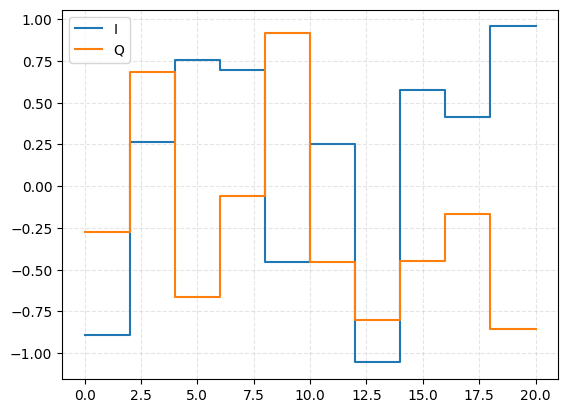

In [6]:
opt_result.plot()

In [7]:
sim_result = optimizer.simulate(opt_result.pulse)

In [8]:
sim_result.print_final_populations()

|0> : 100.00%
|1> :  0.00%
|2> :  0.00%


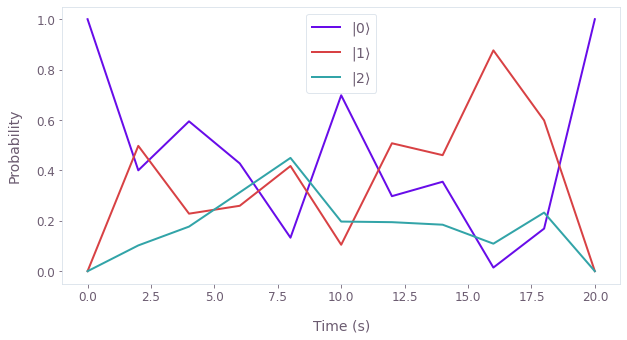

In [9]:
sim_result.plot_populations()

In [10]:
sim_result.display_bloch_sphere()

<IPython.core.display.Javascript object>

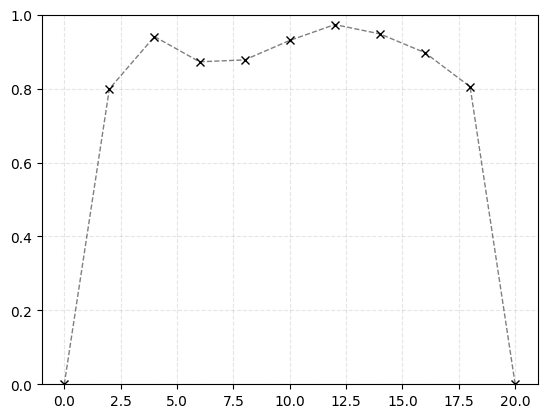

In [11]:
sim_result.plot_unitary_infidelities()